# Lab 14 - CRISP-DM
We will implement the stages of the CRISP-DM pipeline in this lab. We will use the `netattacks` dataset to demonstrate the process.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn import tree
from sklearn import ensemble
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Business Understanding
We need a way to identify malicious traffic on our network and automatically block it. The model should be fast and accurate. 

Criteria (I made these up, but they are reasonable):

1. Recall for benign traffic should exceed 99.99% to avoid blocking legitmate traffic.
2. Recall for malicious traffic should exceed 98%.
3. Precision for malicious traffic should exceed 90% (to avoid excessive false positives).
4. Other criteria (like AUC) could be used as a tie-breaker

# Data 
We will use the KDDCup Network Attack dataset from Labs 2 and 3.

In [4]:
# load txt file
names = pd.read_csv('data/kddcup.names', header=None, delimiter=':',skiprows=1)

# make column 0 into a list
name_list = names[0].tolist()

# add the last column with type
name_list.append('type')

In [12]:
netattacks = pd.read_csv('data/kddcup.data_10_percent_corrected', names=name_list, header=None, index_col=None)

# use a 0 (normal) or 1 (malicious) to code bad traffic
netattacks['label'] = np.where(netattacks['type'] == 'normal.', 0, 1)

netattacks = netattacks.select_dtypes(include=np.number)

# train-test split
train, test = train_test_split(netattacks, test_size=0.25)

## Preprocessing
This dataset is already cleaned and ready for use. Let's view some
descripteve statistics to verify this.

In [13]:
# the display() function works better for displaying dataframes in Jupyter Notebooks than print().
display(netattacks.describe())

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
count,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,...,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06
mean,4.834243e+01,1.834621e+03,1.093623e+03,5.716116e-06,6.487792e-04,7.961733e-06,1.243766e-02,3.205108e-05,1.435290e-01,8.088304e-03,...,1.892142e+02,7.537132e-01,3.071111e-02,6.050520e-01,6.464107e-03,1.780911e-01,1.778859e-01,5.792780e-02,5.765941e-02,8.014097e-01
std,7.233298e+02,9.414311e+05,6.450123e+05,2.390833e-03,4.285434e-02,7.215084e-03,4.689782e-01,7.299408e-03,3.506116e-01,3.856481e+00,...,1.059128e+02,4.111860e-01,1.085432e-01,4.809877e-01,4.125978e-02,3.818382e-01,3.821774e-01,2.309428e-01,2.309777e-01,3.989389e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,4.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,4.900000e+01,4.100000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
50%,0.000000e+00,5.200000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.550000e+02,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,0.000000e+00,1.032000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.550000e+02,1.000000e+00,4.000000e-02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
max,5.832900e+04,1.379964e+09,1.309937e+09,1.000000e+00,3.000000e+00,1.400000e+01,7.700000e+01,5.000000e+00,1.000000e+00,7.479000e+03,...,2.550000e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


## Train/test split
Next, we will use a 75/25 split for this data. We will view
some summarization by outcome `Class` and a few variables.

In [15]:
np.random.seed(516)

# create train and test
train, test = train_test_split(netattacks, test_size=0.25)
print("Rows in train:", len(train))
print("Rows in test:", len(test))

Rows in train: 3673823
Rows in test: 1224608


We will use all of the available predictors

In [16]:
# get columns not label
pred_vars = list(netattacks.columns)

# remove 'label' because it is what we are trying to predict
pred_vars.remove('label')


In [17]:
# rename train and test for easier copy/paste in future projects

train_X = train[pred_vars]
train_y = train['label']

test_X = test[pred_vars]
test_y = test['label']


# Define models
In this section, we will train a several different types of classifiers. They
will be presented one-by-one in this lab, but it is possible to set up the 
training in a `for` loop to make your code simpler and more flexible.



## Decision tree
The first model we fit is a decision tree, which we have been working with for some 
time. 

In [18]:
dtree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=10)


## Random Forest
A random forest classifier consists of many decision trees
with randomized parameters (hence the name). One of the parameters
is the number of trees in the classifier. The default is 100, but 
this can be reduced for large datasets if training is slow.
Full documentation on this implementation is 
[here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [19]:
rf = ensemble.RandomForestClassifier()


## Neural Networks
There are many types of neural networks in use today. We will 
use perhaps the most common type, the Multi-Layer Perceptron (MLP). 
The documentation for this method is 
[here](https://scikit-learn.org/stable/modules/neural_networks_supervised.html).

In [20]:
mlp = MLPClassifier(hidden_layer_sizes=(20,20))

## Support Vector Machines
Next, we will train a support vector machine. The basic 
model works well for linearly separable classes. You may also
want to try an RBF kernel, which can perform better in some situations.

The documentation for SVMs is 
[here](https://scikit-learn.org/stable/modules/svm.html). By default, 
the model only produces label outputs. We will adjust the probability
parameter so that the model can also report class probabilities.

In [21]:
svc = svm.SVC(probability=True)

## Naive Bayes
The Naive Bayes classification algorithm is based on conditional probabilities
from Bayes' Theorem. It is one of the simplest algorithms, yet tends to 
perform quite well in many scenarios.

Documentation for this is 
[here](https://scikit-learn.org/stable/modules/naive_bayes.html).

In [22]:
nb = GaussianNB()

## Logistic Regression
The last method we will use in this lab is the logistic regression.
This a method that has existed in statistics for a long time and,
like decision trees, results in models that are human-interpretable.

The documentation for this method is 
[here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [23]:
lr = LogisticRegression()

# Training & Evaluation
Next, we will train and  
evaluate their performance on out-of-sample data (our test dataset).
We will use multiple evaluation statistics.

The code for this section is adapted from 
[this tutorial](https://abdalimran.github.io/2019-06-01/Drawing-multiple-ROC-Curves-in-a-single-plot),
which seems to be an adaptation of 
[this StackOverflow answer](https://stackoverflow.com/questions/42894871/how-to-plot-multiple-roc-curves-in-one-plot-with-legend-and-auc-scores-in-python).

It works by iterating through the models using a for loop,
and then storing the statistics in a dataframe. These models 
perform poorly, and may result in warning message from `sklearn`. 

In [30]:
# list of our models
model = [dtree, rf, mlp, svc, nb, lr]

# empty dataframe to store the results
result_table = pd.DataFrame(columns=['classifier_name', 'fpr','tpr','auc', 
                                     'log_loss', 'clf_report'])

for clf in model:
    # print the name of the classifier
    print(clf.__class__.__name__)
    
    print('fitting model')
    clf.fit(train_X, train_y)

    print('evaluating model')
    # get predictions
    yproba = clf.predict_proba(test_X)
    yclass = clf.predict(test_X)
    
    # auc information
    fpr, tpr, _ = metrics.roc_curve(test_y,  yproba[:,1])
    auc = metrics.roc_auc_score(test_y, yproba[:,1])
    
    # log loss
    log_loss = metrics.log_loss(test_y, yproba[:,1])
    
    # add some other stats based on confusion matrix
    clf_report = metrics.classification_report(test_y, yclass, digits=6)
    
    # add the results to the dataframe
    result_table = result_table.append({'classifier_name':clf.__class__.__name__,
                                        'classifier': clf,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc,
                                        'log_loss': log_loss,
                                        'clf_report': clf_report}, ignore_index=True)

DecisionTreeClassifier
fitting model
evaluating model


/var/folders/jr/s6jhqyy937nd8zj50rwhkmr00000gn/T/ipykernel_88375/3769792886.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append({'classifier_name':clf.__class__.__name__,


RandomForestClassifier
fitting model


KeyboardInterrupt: 

## View the results
For easy formatting later, reset the dataframe index to be the classifier names
rather than a numeric index.

In [31]:
result_table.set_index('classifier_name', inplace=True)
display(result_table)

,fpr,tpr,auc,log_loss,clf_report,classifier
classifier_name,,,,,,
DecisionTreeClassifier,"[0.0, 5.344076296966209e-05, 5.755159089040533...","[0.0, 0.9988118384100237, 0.9992377831309587, ...",0.999965,0.001125,precision recall f1-score ...,"DecisionTreeClassifier(criterion='entropy', ma..."


The raw dataframe is not very pleasing to look at, so let's work on that next.
First, run a for loop to show the classification report and log loss for 
each model.

In [ ]:
for i in result_table.index:
    print('\n---- statistics for', i, "----\n")
    print(result_table.loc[i, 'clf_report'])
    print("Model log loss:", result_table.loc[i, 'log_loss'])

### Plot the ROC curve
A common technique in comparing models is to 
plot the ROC curve for each model and compare
the shape and the AUC for each. We will use another
for loop to generate the plot, and then
format the axes and titles

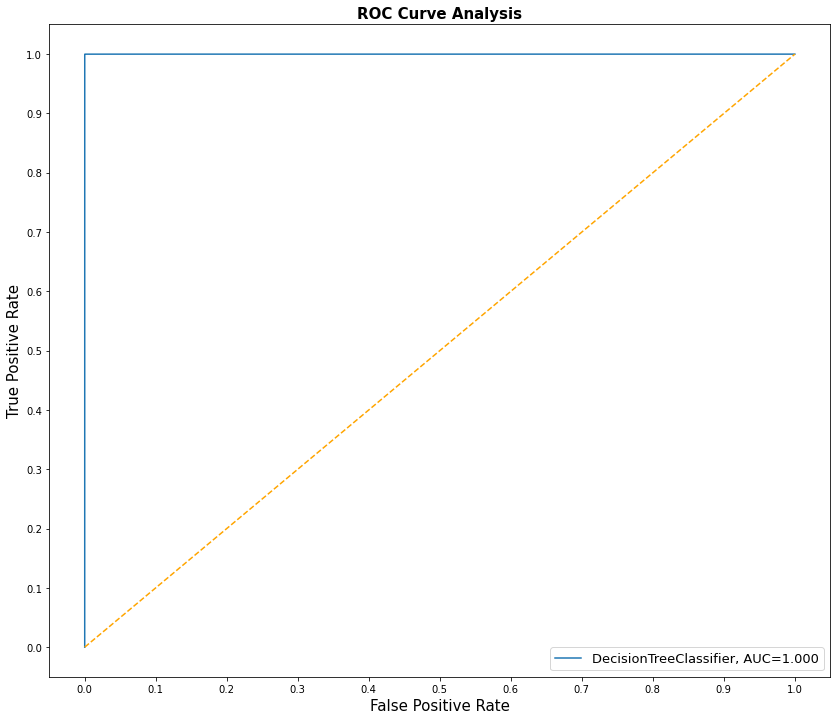

In [33]:
fig = plt.figure(figsize=(14,12))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

# Deploy

Next, we will save the best model. 

In [36]:
# find the model that works the best and pickle it.
import pickle
best_model = result_table.loc[0, 'classifier']

with open('netattack_dtree.pkl','wb') as f:
    pickle.dump(best_model, f)

KeyError: 0